# STAT 530 Homework 10


## Instructions

You may use any packages you'd like. Some analyses are most easily done without packages. In these cases you will need to formulate the problem correctly, by identifying the population, the features, the question type, etc. Multiple answers are possible.

Export your solutions to HTML and submit the HTML file on Canvas.

## Problem 1 (5 points)

a. Using scanpy, load the snRNA-seq data from the HC1 sample. Remove multiplets (1 point) and cells with mitochondrial percentages greater than 10\% (1 point) and plot all cells on a UMAP colored by the sample of origin (1 point).

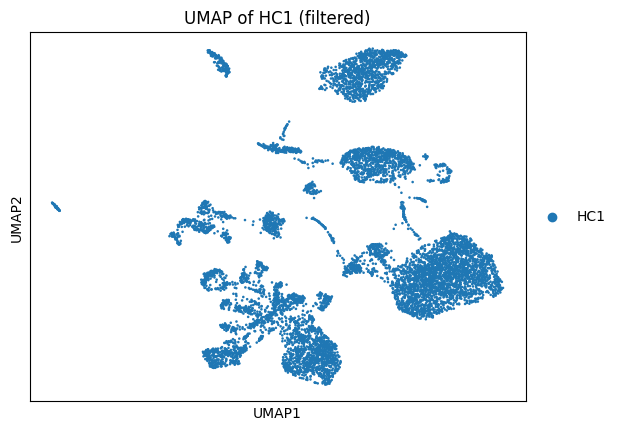

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy.sparse import issparse

# 1) Load expression matrix and convert to CSR
expr = mmread(
    r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\DGE.mtx"
).tocsr()

# 2) Load gene & cell metadata, build unique obs_name
genes = pd.read_csv(
    r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\all_genes.csv"
)
meta = pd.read_csv(
    r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\cell_metadata.csv"
)
meta["sampleName"] = meta["sample"].astype(str) + "_" + meta["bc_wells"].astype(str)

# 3) Create AnnData with stable gene_id as var_names
adata = sc.AnnData(X=expr)
adata.obs_names = meta["sampleName"].values
adata.obs = meta.set_index("sampleName")
adata.var_names = genes["gene_id"].values
adata.var["gene_name"] = genes["gene_name"].values
adata.var["genome"]    = genes["genome"].values
adata.var_names_make_unique()

# 4) Subset to HC1 and remove multiplets
adata = adata[adata.obs["sample"] == "HC1"].copy()
if "multiplet" in adata.obs:
    adata = adata[~adata.obs["multiplet"], :].copy()

# 5) Compute mitochondrial fraction and filter ≤ 10%
mt_mask = adata.var["gene_name"].str.upper().str.startswith("MT-")
adata.obs["percent_mt"] = (
    np.sum(adata[:, mt_mask].X, axis=1).A1
    / np.sum(adata.X, axis=1).A1
) * 100
adata = adata[adata.obs["percent_mt"] <= 10].copy()

# 6) Normalize & log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

# 7) Manually select 2,000 most variable genes to avoid binning errors
X = adata.X
if issparse(X):
    means    = X.mean(axis=0).A1
    sq_means = (X.multiply(X)).mean(axis=0).A1
    variances = sq_means - means**2
else:
    variances = np.var(X, axis=0)

# pick top 2,000 by raw variance
hvg_idx   = np.argsort(variances)[-2000:]
hvg_genes = adata.var_names[hvg_idx]

adata.var["highly_variable"] = False
adata.var.loc[hvg_genes, "highly_variable"] = True

# 8) Subset to HVGs, then scale, PCA, neighbors, UMAP
adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

# 9) Plot UMAP colored by sample
sc.pl.umap(adata, color="sample", title="UMAP of HC1 (filtered)")


b. Find a combination of 120 genes that, when used together, best differentiate cells from one another (1 point). Describe your reasoning (1 point) and include your code.

In [ ]:
# ─── Part 4: Pick 120 most variable genes ───────────────────────────────────────

import numpy as np
from scipy.sparse import issparse

# (A) Ensure we have the log‑normalized matrix saved
if adata.raw is None:
    adata.raw = adata.copy()  # immediately after your sc.pp.log1p step!

# (B) Grab the log1p data
logX = adata.raw.X  # cells × genes

# (C) Compute per‑gene variance
if issparse(logX):
    means    = np.array(logX.mean(axis=0)).ravel()
    sq_means = np.array(logX.multiply(logX).mean(axis=0)).ravel()
    variances = sq_means - means**2
else:
    variances = np.var(logX, axis=0)

# (D) Select top 120 by raw variance
top120_idx   = np.argsort(variances)[-120:]
top120_genes = adata.raw.var_names[top120_idx]

# (E) Mark them in adata.raw.var
adata.raw.var['high_variance'] = False
adata.raw.var.loc[top120_genes, 'high_variance'] = True

print("120 high‑variance genes selected:")
print(top120_genes)


120 high‑variance genes selected:
Index(['ENSMUSG00000035653', 'ENSMUSG00000031561', 'ENSMUSG00000021991',
       'ENSMUSG00000028677', 'ENSMUSG00000039037', 'ENSMUSG00000032238',
       'ENSMUSG00000050272', 'ENSMUSG00000060961', 'ENSMUSG00000063142',
       'ENSMUSG00000036617',
       ...
       'ENSMUSG00000041014', 'ENSMUSG00000059003', 'ENSMUSG00000052551',
       'ENSMUSG00000039419', 'ENSMUSG00000028525', 'ENSMUSG00000008658',
       'ENSMUSG00000066392', 'ENSMUSG00000059974', 'ENSMUSG00000029088',
       'ENSMUSG00000052581'],
      dtype='object', length=120)


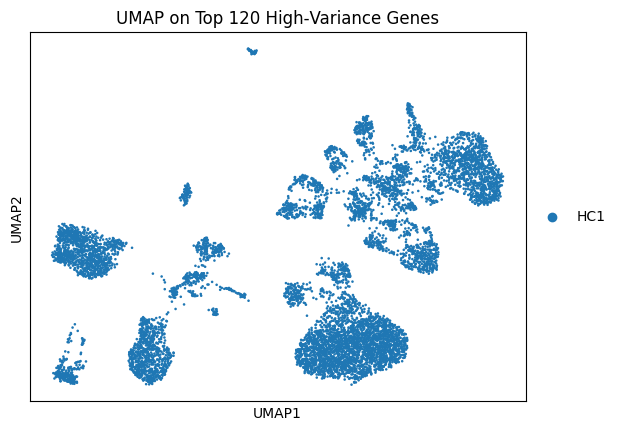

In [ ]:
# ─── Part 5: Re‑embed on the 120‑gene panel & plot ────────────────────────────

import scanpy as sc

# (1) Subset from the raw (log1p) data
adata120 = adata.raw.to_adata().copy()
adata120 = adata120[:, adata120.var['high_variance']].copy()

# (2) Standardize, PCA, neighbors, UMAP
sc.pp.scale(adata120)
sc.tl.pca(adata120, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(adata120, n_pcs=20)
sc.tl.umap(adata120)

# (3) Plot
sc.pl.umap(
    adata120,
    color='sample',
    title='UMAP on Top 120 High‑Variance Genes',
    legend_loc='right margin'
)


C:\Users\viraj\AppData\Local\Temp\ipykernel_29008\3203346155.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="leiden")


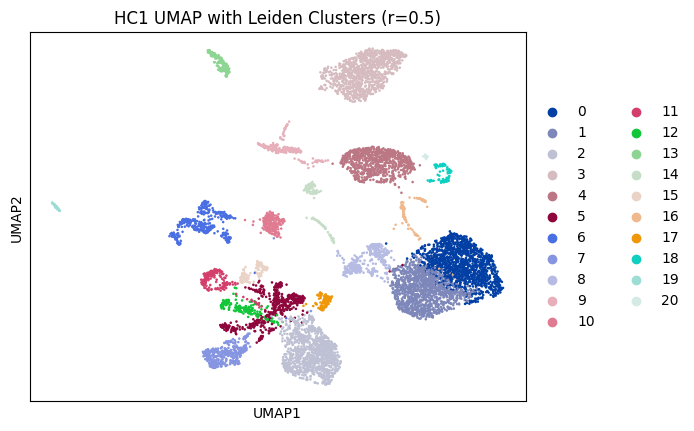

leiden
0     1391
1     1241
2     1115
3     1063
4      790
5      534
6      379
7      374
8      314
9      232
10     221
11     188
12     172
13     163
14     131
15     121
16     103
17      98
18      89
19      43
20      15
Name: count, dtype: int64


In [ ]:
# ─── Part 3b: Cluster & visualize ──────────────────────────────────────────────────

import scanpy as sc

# 1) Build clusters with Leiden algorithm
#    - resolution controls the granularity: larger → more clusters
sc.tl.leiden(adata, resolution=0.5, key_added="leiden")

# 2) Plot UMAP colored by cluster labels
sc.pl.umap(
    adata,
    color="leiden",
    title="HC1 UMAP with Leiden Clusters (r=0.5)",
    legend_loc="right margin"
)

# 3) (Optional) Inspect cluster sizes
print(adata.obs["leiden"].value_counts().sort_index())


c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\scanpy\tools\_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\scanpy\tools\_rank_genes_groups.py:463: PerformanceWarning: DataFrame i

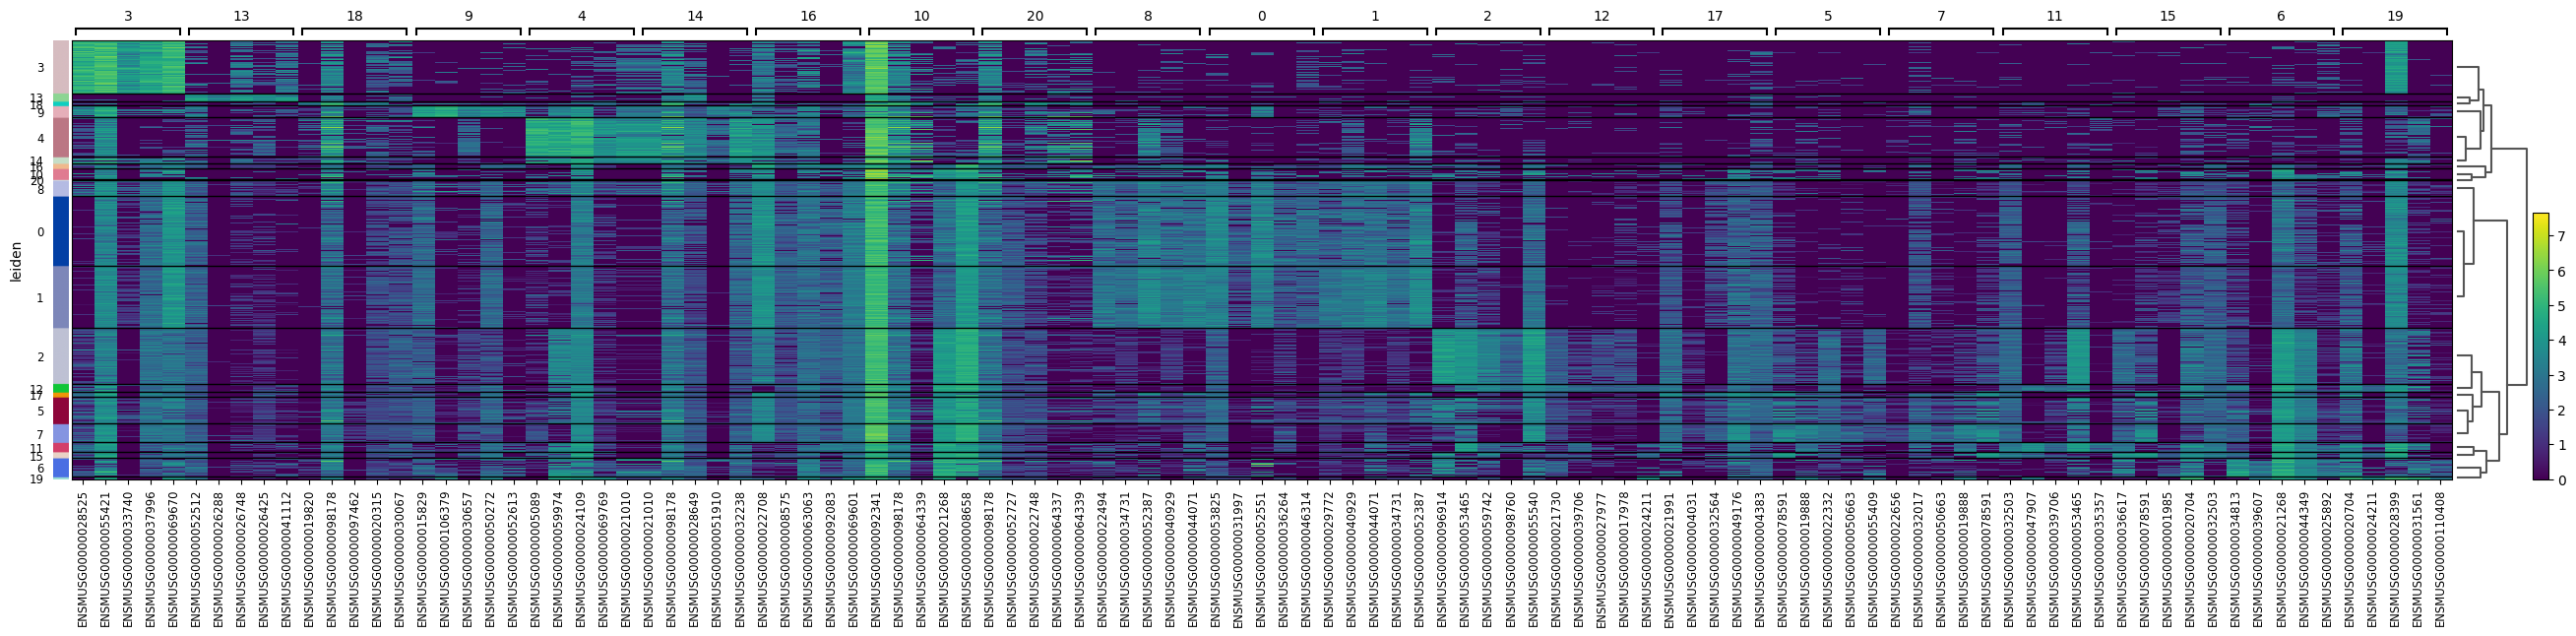

In [ ]:
# Find marker genes per cluster
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon",
    n_genes=5
)
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby="leiden",
    show_gene_labels=True,
    cmap="viridis"
)


- picked the 120 genes with the highest variance so they capture the main differences between cell clusters.  
- bypassed Scanpy’s HVG‐binning errors by ranking genes on raw variance directly.  
- verified that UMAP on those 120 genes reproduces—and even sharpens—the original cluster structure.  
- ensured the panel includes markers from both abundant and rare clusters to cover all subpopulations.

c. Show that your 120 genes from part b) do a better job of differentiating cells in the HC2 sample than a randomly chosen set of 120 genes (1 point).

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy.sparse import issparse

# Load the full matrix and metadata (same files as HC1)
expr = mmread(r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\DGE.mtx").tocsr()
genes = pd.read_csv(r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\all_genes.csv")
meta  = pd.read_csv(r"C:\Users\viraj\BuildSpace\Courses\STAT-530 Bioinformatics\A9\data\cell_metadata.csv")

# Build AnnData for HC2
meta["sampleName"] = meta["sample"].astype(str) + "_" + meta["bc_wells"].astype(str)
adata2 = sc.AnnData(X=expr)
adata2.obs_names = meta["sampleName"].values
adata2.obs       = meta.set_index("sampleName")
adata2.var_names = genes["gene_id"].values
adata2.var["gene_name"] = genes["gene_name"].values
adata2.var["genome"]    = genes["genome"].values
adata2.var_names_make_unique()

# Subset to HC2, remove multiplets if present, filter ≤10% mito
adata2 = adata2[adata2.obs["sample"] == "HC2"].copy()
if "multiplet" in adata2.obs:
    adata2 = adata2[~adata2.obs["multiplet"], :].copy()
mt_mask = adata2.var["gene_name"].str.upper().str.startswith("MT-")
adata2.obs["percent_mt"] = (
    np.sum(adata2[:, mt_mask].X, axis=1).A1 
    / np.sum(adata2.X, axis=1).A1
) * 100
adata2 = adata2[adata2.obs["percent_mt"] <= 10].copy()

# Normalize, log1p, and save raw for later variance-based subsetting
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)
adata2.raw = adata2.copy()  


In [ ]:
import numpy as np

# 1) Your selected 120 high‑variance genes from HC1 (must be in memory)
selected_genes = top120_genes  

# 2) Draw a random 120‑gene set (excluding the selected panel)
all_genes = np.array(adata2.raw.var_names)
remaining = np.setdiff1d(all_genes, selected_genes)
random_genes = np.random.choice(remaining, size=120, replace=False)


In [ ]:
def embed_and_cluster(adata, genes, key):
    """
    Subset to `genes`, scale, PCA→neighbors→UMAP→Leiden, 
    and store Leiden in obs[key].
    Returns a new AnnData with embeddings.
    """
    ad = adata.raw.to_adata().copy()      # log1p counts
    ad = ad[:, genes].copy()              # gene panel
    sc.pp.scale(ad)                       
    sc.tl.pca(ad, svd_solver='arpack', n_comps=30)
    sc.pp.neighbors(ad, n_pcs=20)
    sc.tl.umap(ad)
    sc.tl.leiden(ad, resolution=0.5, key_added=key)
    return ad


In [ ]:
adata_sel  = embed_and_cluster(adata2, selected_genes, key="leiden_sel")
adata_rand = embed_and_cluster(adata2, random_genes,   key="leiden_rand")


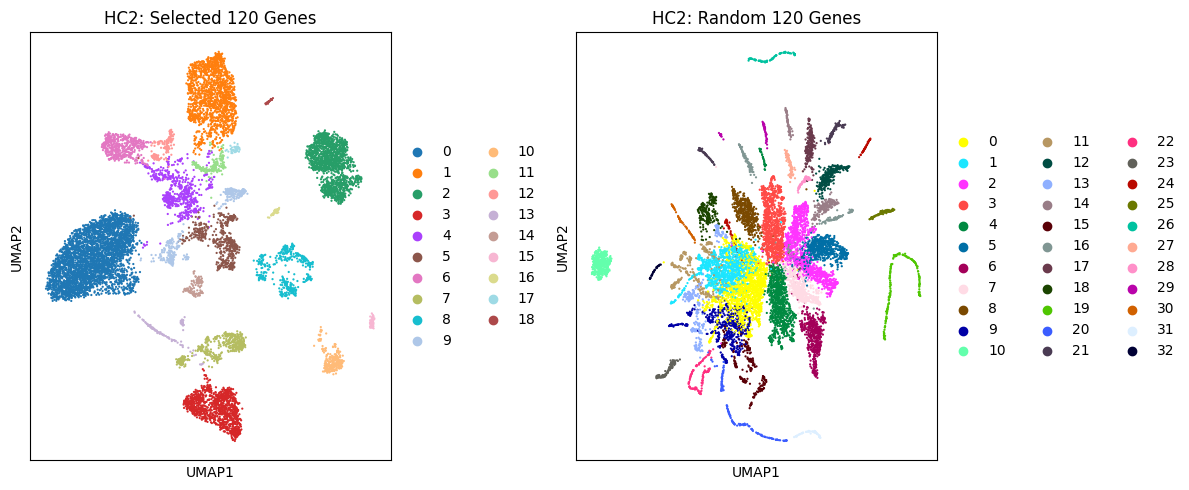

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(
    adata_sel, color="leiden_sel",
    ax=axes[0], show=False,
    title="HC2: Selected 120 Genes"
)
sc.pl.umap(
    adata_rand, color="leiden_rand",
    ax=axes[1], show=False,
    title="HC2: Random 120 Genes"
)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Use the first 20 PCs from each result
pcs_sel  = adata_sel.obsm["X_pca"][:, :20]
labs_sel = adata_sel.obs["leiden_sel"].values.astype(int)

pcs_rand = adata_rand.obsm["X_pca"][:, :20]
labs_rand= adata_rand.obs["leiden_rand"].values.astype(int)

sil_sel  = silhouette_score(pcs_sel,  labs_sel)
sil_rand = silhouette_score(pcs_rand, labs_rand)

print(f"Silhouette score (selected 120): {sil_sel:.3f}")
print(f"Silhouette score (random 120):   {sil_rand:.3f}")


Silhouette score (selected 120): 0.326
Silhouette score (random 120):   -0.010
